In [1]:
#!pip install efficientnet_pytorch tqdm albumentations imgaug fastai

In [2]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available?:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("⚠ No GPU detected — training will run on CPU")


PyTorch version: 2.3.1+cu121
CUDA available?: True
CUDA device count: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [3]:
import fastai
import fastcore
import fastdownload
import fastprogress
print(f"fastai: {fastai.__version__}")
print(f"fastcore: {fastcore.__version__}")
print("FastAI import OK")
from fastai.vision.all import *
print("FastAI vision imported successfully")

fastai: 2.7.18
fastcore: 1.7.20
FastAI import OK
FastAI vision imported successfully


In [4]:
# -------------------------
# Imports
# -------------------------
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
import PIL
from tqdm import tqdm

from imgaug import augmenters as iaa
import imgaug as ia
import numpy as np
from fastai.vision.all import *
import albumentations

from augmentations_file import *
#from utils import *
from data_parallel import *

import torch
import torchvision
import os
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt


In [5]:
import torch
import torch.nn.functional as F


def accuracy(outputs, labels):
    """
    Compute accuracy of predictions vs true labels.
    outputs: logits from model (batch_size x num_classes)
    labels: ground truth class indices
    """
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def validation_step(model, batch):
    """
    Process a validation batch. Returns a dictionary with loss and accuracy.
    """
    images, labels = batch
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    acc = accuracy(outputs, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc.detach()}


def validation_epoch_end(model, outputs):
    """
    Combine validation results for the entire epoch.
    outputs: list of dicts from validation_step()
    """
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean().item()

    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean().item()

    return {'val_loss': epoch_loss, 'val_acc': epoch_acc}


def epoch_end(model, epoch, result):
    """
    Print epoch summary after each epoch.
    """
    print(f"Epoch [{epoch+1}]: "
          f"Train Loss: {result.get('train_loss', 0):.4f}, "
          f"Val Loss: {result['val_loss']:.4f}, "
          f"Val Acc: {result['val_acc']:.4f}")


In [6]:
# -------------------------
# Evaluation Step
# -------------------------
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(model, outputs)


# -------------------------
# Training Loop (with tqdm)
# -------------------------
def fit(epochs, lr, model, train_loader, val_loader,
        opt_func=torch.optim.Adam,
        model_save_direc="Saved_Models"):

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": []
    }

    optimizer = opt_func(model.parameters(), lr)
    save_idx = 1

    for epoch in range(epochs):
        model.train()
        train_losses = []

        progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in progress:
            images, labels = batch
            out = model(images)
            loss = F.cross_entropy(out, labels)
            train_losses.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            progress.set_postfix({"loss": loss.item()})

        # Validation
        val_result = evaluate(model, val_loader)
        val_loss = val_result["val_loss"]
        val_acc = val_result["val_acc"]

        # Logging
        history["train_loss"].append(np.mean(train_losses))
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {history['train_loss'][-1]:.4f}")
        print(f"Val Loss:   {val_loss:.4f}")
        print(f"Val Acc:    {val_acc:.4f}")

        # Save checkpoints
        torch.save(model, os.path.join(model_save_direc, f"{save_idx}_d60.pth"))
        save_idx += 1

    return history


In [7]:
import numpy as np
from torch.utils.data import WeightedRandomSampler
def fake_dataset(tfms, data_dir="Datasets"):
    train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=tfms)
    valid_dataset = ImageFolder(os.path.join(data_dir, 'valid'), transform=tfms)
    return train_dataset, valid_dataset


def fake_dataloader(train_ds, val_ds, batch_size=8, device="cpu"):
    

    targets = np.array(train_ds.targets)
    class_sample_count = np.array([
        len(np.where(targets == 0)[0]),
        len(np.where(targets == 1)[0])
    ])
    weights = 1. / class_sample_count
    sample_weights = weights[targets]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_dl = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    train_dl = DeviceDataLoader(train_dl, device)
    val_dl = DeviceDataLoader(val_dl, device)

    return train_dl, val_dl


In [8]:
def train(path="Datasets", batch_size=8, epochs=5,
          model=None, device="cpu", model_save_direc="Saved_Models"):

    stats = ((0.4914, 0.4822, 0.4465),
             (0.2023, 0.1994, 0.2010))

    transforms = torchvision.transforms.Compose([
        ImgAugTransform(),
        lambda x: PIL.Image.fromarray(x),
        torchvision.transforms.RandomVerticalFlip(),
        tt.RandomHorizontalFlip(),
        tt.RandomResizedCrop((224, 224), interpolation=2),
        tt.ToTensor(),
        tt.Normalize(*stats, inplace=True)
    ])

    train_ds, val_ds = fake_dataset(transforms, data_dir=path)
    train_dl, val_dl = fake_dataloader(train_ds, val_ds,
                                       batch_size=batch_size,
                                       device=device)

    lr = 0.0004

    history = fit(
        epochs=epochs,
        lr=lr,
        model=model,
        train_loader=train_dl,
        val_loader=val_dl,
        opt_func=torch.optim.Adam,
        model_save_direc=model_save_direc
    )

    return history


In [9]:
class model_architectures:

    def __init__(self, model_id=7):
        self.model_id = model_id
        self.model = None

    def efficientnet_architectures(self):

        if self.model_id == 7:
            self.model = EfficientNet.from_pretrained("efficientnet-b7", advprop=True)
            self.model._fc = nn.Linear(2560, 2)

        elif self.model_id == 6:
            self.model = EfficientNet.from_pretrained("efficientnet-b6", advprop=True)
            self.model._fc = nn.Linear(2304, 2)

        elif self.model_id == 5:
            self.model = EfficientNet.from_pretrained("efficientnet-b5", advprop=True)
            self.model._fc = nn.Linear(2048, 2)

        else:
            raise ValueError("Use 5,6,7 for large models")

        return self.model


In [10]:
# --- Training Settings ---
model_id = 7            # EfficientNet-B7
batch_size = 8          # Adjust for GPU
epochs = 20            # Recommended for testing
dataset_path = r"E:\CVL\finalproject\Model Testing\Datasets\Datasets"
save_dir = "Saved_Models"

os.makedirs(save_dir, exist_ok=True)

# --- Load model ---
builder = model_architectures(model_id)
model = builder.efficientnet_architectures()

device = get_default_device()
model = to_device(model, device)

# --- Train ---
history = train(
    path=dataset_path,
    batch_size=batch_size,
    epochs=epochs,
    model=model,
    device=device,
    model_save_direc=save_dir
)


Loaded pretrained weights for efficientnet-b7


Epoch 1/20: 100%|██████████████████████████████████████████████████████| 2273/2273 [14:23<00:00,  2.63it/s, loss=0.525]



Epoch 1 Summary:
Train Loss: 0.6548
Val Loss:   0.5730
Val Acc:    0.6921


Epoch 2/20: 100%|██████████████████████████████████████████████████████| 2273/2273 [13:58<00:00,  2.71it/s, loss=0.439]



Epoch 2 Summary:
Train Loss: 0.5814
Val Loss:   0.5173
Val Acc:    0.7450


Epoch 3/20: 100%|██████████████████████████████████████████████████████| 2273/2273 [13:48<00:00,  2.74it/s, loss=0.942]



Epoch 3 Summary:
Train Loss: 0.5328
Val Loss:   0.4325
Val Acc:    0.7987


Epoch 4/20: 100%|██████████████████████████████████████████████████████| 2273/2273 [13:42<00:00,  2.76it/s, loss=0.354]



Epoch 4 Summary:
Train Loss: 0.4988
Val Loss:   0.5176
Val Acc:    0.7375


Epoch 5/20: 100%|██████████████████████████████████████████████████████| 2273/2273 [13:48<00:00,  2.74it/s, loss=0.624]



Epoch 5 Summary:
Train Loss: 0.4755
Val Loss:   0.3769
Val Acc:    0.8282


Epoch 6/20: 100%|██████████████████████████████████████████████████████| 2273/2273 [14:12<00:00,  2.67it/s, loss=0.507]



Epoch 6 Summary:
Train Loss: 0.4490
Val Loss:   0.4140
Val Acc:    0.8064


Epoch 7/20: 100%|██████████████████████████████████████████████████████| 2273/2273 [13:55<00:00,  2.72it/s, loss=0.561]



Epoch 7 Summary:
Train Loss: 0.4196
Val Loss:   0.3723
Val Acc:    0.8251


Epoch 8/20: 100%|██████████████████████████████████████████████████████| 2273/2273 [13:39<00:00,  2.77it/s, loss=0.351]



Epoch 8 Summary:
Train Loss: 0.4063
Val Loss:   0.3668
Val Acc:    0.8257


Epoch 9/20: 100%|██████████████████████████████████████████████████████| 2273/2273 [13:30<00:00,  2.81it/s, loss=0.252]



Epoch 9 Summary:
Train Loss: 0.3839
Val Loss:   0.3493
Val Acc:    0.8410


Epoch 10/20: 100%|█████████████████████████████████████████████████████| 2273/2273 [13:05<00:00,  2.89it/s, loss=0.949]



Epoch 10 Summary:
Train Loss: 0.3742
Val Loss:   0.3991
Val Acc:    0.8139


Epoch 11/20: 100%|██████████████████████████████████████████████████████| 2273/2273 [13:12<00:00,  2.87it/s, loss=0.27]



Epoch 11 Summary:
Train Loss: 0.3580
Val Loss:   0.3604
Val Acc:    0.8299


Epoch 12/20: 100%|█████████████████████████████████████████████████████| 2273/2273 [13:10<00:00,  2.87it/s, loss=0.479]



Epoch 12 Summary:
Train Loss: 0.3508
Val Loss:   0.3933
Val Acc:    0.8087


Epoch 13/20: 100%|█████████████████████████████████████████████████████| 2273/2273 [13:02<00:00,  2.91it/s, loss=0.084]



Epoch 13 Summary:
Train Loss: 0.3398
Val Loss:   0.3753
Val Acc:    0.8105


Epoch 14/20: 100%|█████████████████████████████████████████████████████| 2273/2273 [12:57<00:00,  2.92it/s, loss=0.249]



Epoch 14 Summary:
Train Loss: 0.3397
Val Loss:   0.3236
Val Acc:    0.8572


Epoch 15/20: 100%|█████████████████████████████████████████████████████| 2273/2273 [13:08<00:00,  2.88it/s, loss=0.572]



Epoch 15 Summary:
Train Loss: 0.3233
Val Loss:   0.3199
Val Acc:    0.8594


Epoch 16/20: 100%|█████████████████████████████████████████████████████| 2273/2273 [13:01<00:00,  2.91it/s, loss=0.429]



Epoch 16 Summary:
Train Loss: 0.3163
Val Loss:   0.3388
Val Acc:    0.8468


Epoch 17/20: 100%|█████████████████████████████████████████████████████| 2273/2273 [13:02<00:00,  2.90it/s, loss=0.123]



Epoch 17 Summary:
Train Loss: 0.3189
Val Loss:   0.3315
Val Acc:    0.8552


Epoch 18/20: 100%|█████████████████████████████████████████████████████| 2273/2273 [17:20<00:00,  2.18it/s, loss=0.143]



Epoch 18 Summary:
Train Loss: 0.3074
Val Loss:   0.3093
Val Acc:    0.8635


Epoch 19/20: 100%|█████████████████████████████████████████████████████| 2273/2273 [18:07<00:00,  2.09it/s, loss=0.415]



Epoch 19 Summary:
Train Loss: 0.3064
Val Loss:   0.3224
Val Acc:    0.8551


Epoch 20/20: 100%|████████████████████████████████████████████████████| 2273/2273 [18:09<00:00,  2.09it/s, loss=0.0456]



Epoch 20 Summary:
Train Loss: 0.2966
Val Loss:   0.3152
Val Acc:    0.8601


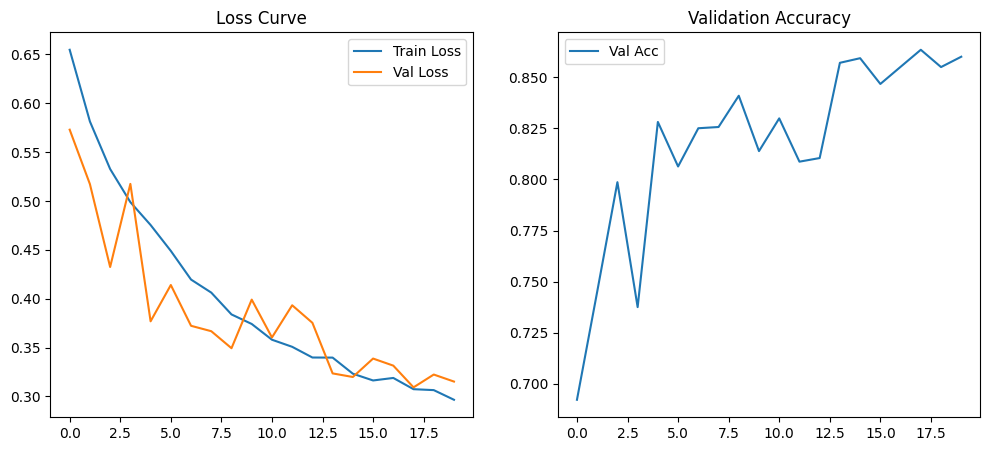

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["val_acc"])
plt.title("Validation Accuracy")
plt.legend(["Val Acc"])

plt.show()


In [12]:
# =========================================================
# =============== 🔥 Testing / Evaluation ==================
# =========================================================

print("\n===== TESTING MODEL =====")

# ---- Select model checkpoint to load ----
best_model_path = os.path.join(save_dir, "5_d60.pth")   # change checkpoint index if needed
print("Loading model from:", best_model_path)

model = torch.load(best_model_path)
model = to_device(model, device)
model.eval()

# ---- Test set path ----
test_path = os.path.join(dataset_path, "valid")   # using validation folder as test folder

# ---- Same transforms as training (without randomness) ----
stats = ((0.4914, 0.4822, 0.4465),
         (0.2023, 0.1994, 0.2010))

test_tfms = torchvision.transforms.Compose([
    ImgAugTransform(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(*stats, inplace=True)
])

# ---- Create Dataset + Loader ----
test_dataset = ImageFolder(test_path, transform=test_tfms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
class_names = test_dataset.classes
print("Detected Classes:", class_names)

# ---- Evaluate ----
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# ---- Metrics ----
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

acc = accuracy_score(all_labels, all_preds)
print(f"\n🔥 Final Test Accuracy: {acc:.4f}\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ---- Confusion Matrix ----
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---- Visualize predictions for individual samples ----
def show_prediction(idx=0):
    img_path, true_label = test_dataset.samples[idx]
    img = PIL.Image.open(img_path).convert("RGB")

    input_img = test_tfms(np.array(img)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_img)
        _, pred = torch.max(output, 1)

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Actual: {class_names[true_label]} | Predicted: {class_names[pred.item()]}")
    plt.show()

print("\n📌 Call show_prediction(index) to visualize a sample prediction.")
print("Example: show_prediction(10)")



===== TESTING MODEL =====
Loading model from: Saved_Models\5_d60.pth


Evaluating:   0%|                                                                     | 1/1060 [00:00<03:17,  5.36it/s]

Detected Classes: ['fake', 'real']


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 1060/1060 [03:05<00:00,  5.70it/s]



🔥 Final Test Accuracy: 0.8457

              precision    recall  f1-score   support

        fake       0.89      0.87      0.88      5553
        real       0.76      0.80      0.78      2926

    accuracy                           0.85      8479
   macro avg       0.83      0.84      0.83      8479
weighted avg       0.85      0.85      0.85      8479



NameError: name 'sns' is not defined

<Figure size 500x400 with 0 Axes>